# 1. Exploratory Data Analysis (EDA)

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Load the Parquet file as a lazy Polars DataFrame
lazy_df = pl.scan_parquet('../data/transactions.parquet')

num_rows = lazy_df.select(pl.len()).collect().item()
num_cols = len(lazy_df.collect_schema().names())
print('Dataframe shape:', (num_rows, num_cols))

Dataframe shape: (307532073, 23)


In [3]:
# Convert SHOP_DATE to datetime and drop unnecessary columns
lazy_df = (
    lazy_df
    .with_columns(
        pl.col("SHOP_DATE").cast(pl.Utf8).str.strptime(pl.Date, format="%Y%m%d")
    )
    .drop([
        'CUST_CODE',
        'BASKET_ID',
        'BASKET_SIZE',
        '__null_dask_index__'
    ])
)

## Dates validation

In [4]:
# Products without missing days
products_no_missing_list = (
    lazy_df
    .group_by("PROD_CODE")
    .agg([
        pl.col("SHOP_DATE").min().alias("min_date"),
        pl.col("SHOP_DATE").max().alias("max_date"),
        pl.col("SHOP_DATE").n_unique().alias("unique_dates")
    ])
    .with_columns(
        (pl.col("max_date") - pl.col("min_date")).dt.total_days().alias("expected_days")
    )
    .with_columns(
        (pl.col("expected_days") + 1 - pl.col("unique_dates")).alias("missing_days")
    )
    .filter(pl.col("missing_days") == 0)
    .select("PROD_CODE")
    .collect()
    .to_series()
    .to_list()
)


## Top 100 Products

In [5]:
# Create a list of the top 100 products
top_100_products_list = (
    lazy_df
    .group_by("PROD_CODE")
    .agg(pl.sum("SPEND").alias("total_sales"))
    .sort("total_sales", descending=True)
    .limit(100)
    .select("PROD_CODE")
    .collect()
    .to_series()
    .to_list()
)


In [6]:
# Valid products
combined_products_list = list(set(products_no_missing_list) & set(top_100_products_list))

In [7]:
len(combined_products_list)

82

## Daily Aggregation

In [9]:
# 5. Dataframe for main analysis
product_daily = (
    lazy_df
    .filter(pl.col("PROD_CODE").is_in(combined_products_list))
    .with_columns(
        (pl.col("SPEND") / pl.col("QUANTITY")).alias("PRICE")
    )
    .group_by(["SHOP_DATE", "PROD_CODE"])
    .agg([
        pl.mean("PRICE").alias("avg_price"),
        pl.sum("QUANTITY").alias("total_units"),
        pl.sum("SPEND").alias("total_sales")
    ])
    .sort(["SHOP_DATE", "PROD_CODE"])
    .collect(engine="streaming")
)

num_rows, num_cols = product_daily.shape
print('Final Dataframe shape:', (num_rows, num_cols))

Final Dataframe shape: (66969, 5)


## Price and Units Analysis

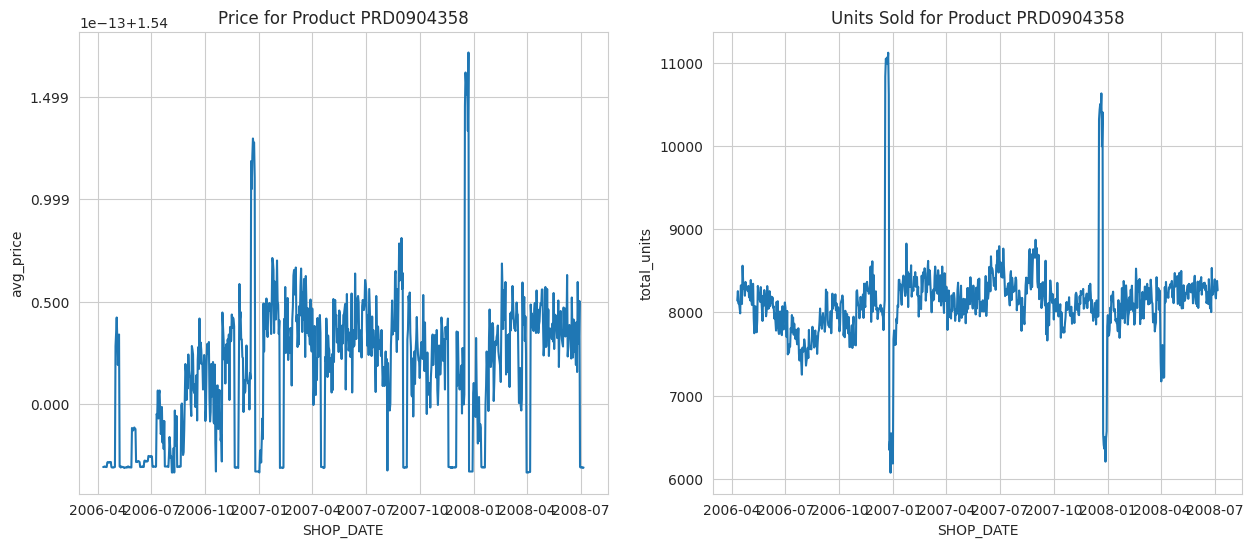

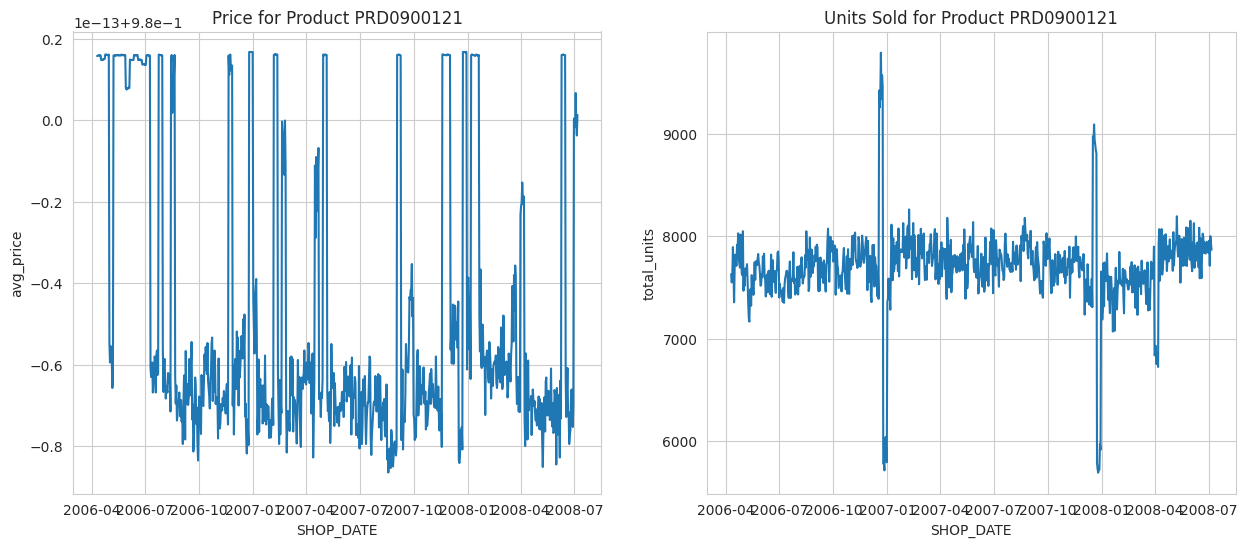

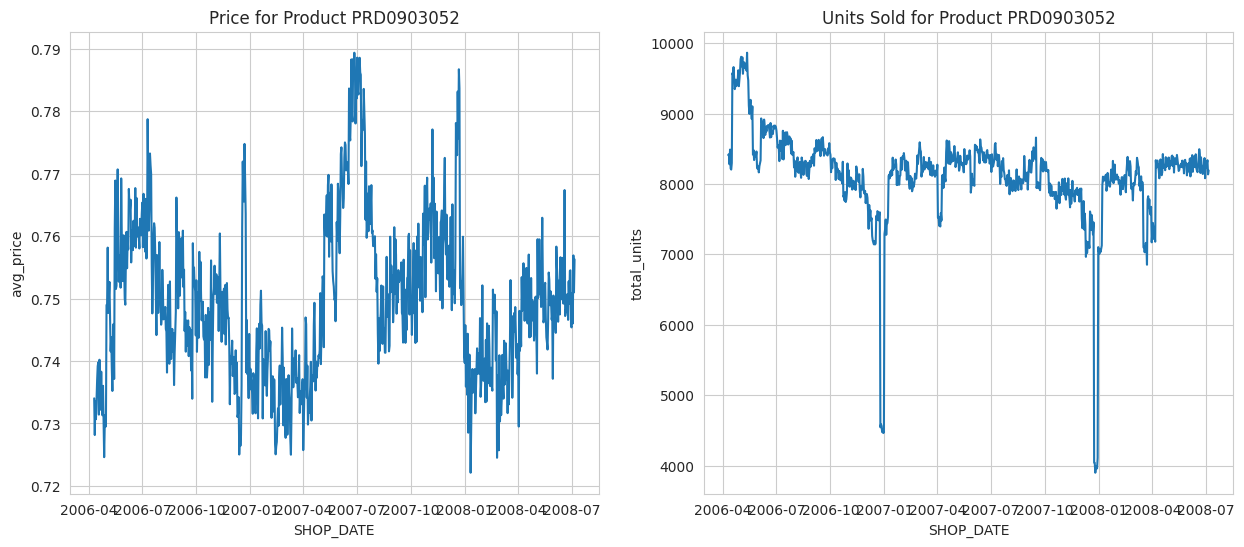

In [14]:
sample_product_ids = top_100_ids.head(3).to_list()

for product_id in sample_product_ids:
    product_df = product_daily.filter(pl.col("PROD_CODE") == product_id).collect().to_pandas()
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.lineplot(data=product_df, x="SHOP_DATE", y="avg_price")
    plt.title(f"Price for Product {product_id}")
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=product_df, x="SHOP_DATE", y="total_units")
    plt.title(f"Units Sold for Product {product_id}")
    
    plt.show()

## Validations

In [16]:
price_outliers = (
    product_daily
    .group_by("PROD_CODE")
    .agg([
        pl.min("avg_price").alias("min_price"),
        pl.max("avg_price").alias("max_price"),
        pl.mean("avg_price").alias("avg_price")
    ])
    .with_columns((pl.col("max_price") / pl.col("avg_price")).alias("price_ratio"))
    .sort("price_ratio", descending=True)
)

price_outliers.collect().head(10)


PROD_CODE,min_price,max_price,avg_price,price_ratio
str,f64,f64,f64,f64
"""PRD0902503""",5.288604,10.866492,6.996081,1.553226
"""PRD0903107""",9.205094,16.657867,12.131114,1.373152
"""PRD0900302""",0.81994,1.320181,1.037059,1.273004
"""PRD0900324""",6.051353,9.285718,7.323704,1.267899
"""PRD0900173""",1.334461,1.802244,1.444853,1.247355
"""PRD0900239""",1.268808,1.884921,1.539881,1.224069
"""PRD0902112""",11.582532,15.87939,13.247109,1.198706
"""PRD0904902""",8.241584,11.365862,9.507764,1.19543
"""PRD0904486""",5.555724,7.337808,6.200719,1.18338


In [17]:
quantity_outliers = (
    product_daily
    .group_by("PROD_CODE")
    .agg([
        pl.min("total_units").alias("min_units"),
        pl.max("total_units").alias("max_units"),
        pl.mean("total_units").alias("avg_units")
    ])
    .with_columns((pl.col("max_units") / pl.col("avg_units")).alias("units_ratio"))
    .sort("units_ratio", descending=True)
)

quantity_outliers.collect().head(10)

PROD_CODE,min_units,max_units,avg_units,units_ratio
str,i64,i64,f64,f64
"""PRD0903578""",6,1801,99.539683,18.093287
"""PRD0900803""",20,3554,222.084249,16.002936
"""PRD0901675""",12,935,59.180708,15.799067
"""PRD0903622""",5,1266,86.010989,14.719049
"""PRD0904942""",9,981,88.981685,11.024741
"""PRD0902066""",10,857,93.566545,9.159257
"""PRD0904014""",79,2862,329.74359,8.679471
"""PRD0901310""",8,1301,154.140415,8.440356
"""PRD0901923""",21,2324,276.604396,8.401891


In [ ]:
# Products without missing days
products_no_missing = (
    lazy_df
    .group_by("PROD_CODE")
    .agg([
        pl.col("SHOP_DATE").min().alias("min_date"),
        pl.col("SHOP_DATE").max().alias("max_date"),
        pl.col("SHOP_DATE").n_unique().alias("unique_dates")
    ])
    .with_columns(
        (pl.col("max_date") - pl.col("min_date")).dt.total_days().alias("expected_days")
    )
    .with_columns(
        (pl.col("expected_days") + 1 - pl.col("unique_dates")).alias("missing_days")
    )
    .filter(pl.col("missing_days") == 0)
    .select("PROD_CODE")
)
count_products = products_no_missing.select(pl.len()).collect().item()
print(f"Number of products without missing days: {count_products}")

## Feature Engineering

In [ ]:
daily_agg_with_features_lazy = daily_agg_lazy.with_columns([
    # Time-based features
    pl.col("date").dt.weekday().alias("day_of_week"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.weekday().is_in([6, 7]).alias("is_weekend"),
    
    # Lag features
    pl.col("total_units").shift(1).over("product_id").alias("lag_1_units"),
    pl.col("total_units").shift(7).over("product_id").alias("lag_7_units"),
    pl.col("total_units").shift(30).over("product_id").alias("lag_30_units"),
    
    # Rolling mean features
    pl.col("total_units").rolling_mean(7).over("product_id").alias("rolling_mean_7_units"),
    pl.col("total_units").rolling_mean(30).over("product_id").alias("rolling_mean_30_units"),
    
    # Price change feature
    (pl.col("avg_price") / pl.col("avg_price").shift(1) - 1).over("product_id").alias("price_change_pct")
])

print("Schema with new features:")
print(daily_agg_with_features_lazy.schema)

print("Head with new features:")
daily_agg_with_features_lazy.head().collect()